# CNN (Convolutional Neural Networks)

In [11]:
%matplotlib inline

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, \
                                    Activation, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import YouTubeVideo
from PIL import Image

In [69]:
def plot(X):
    plt.imshow(X, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

def apply_filter(X, F):
    x, y = X.shape
    filter_x, filter_y = F.shape
    X_with_filter = np.zeros(shape=(x - filter_x, y - filter_y))

    for i in range(x - filter_x):
        for j in range(y - filter_y):
            X_with_filter[i, j] = (X[i:(i+filter_x), j:(j+filter_y)] * F).sum()
    
    return X_with_filter

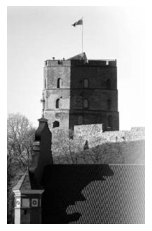

In [70]:
img = Image.open('img/castle.jpg')
img.load()
X = np.asarray(img, dtype="int32") / 255
# X = X.mean(axis=2) / 255
plot(X)

## Filters

It turns out that by sliding simple matrix over an image we can achieve neat things.

Multiplication by sliding matrix can be thought of as **filter**.

<img src="https://cdn-images-1.medium.com/max/900/1*7S266Kq-UCExS25iX_I_AQ.png" style="width: 70%"/>

### Simple box blur

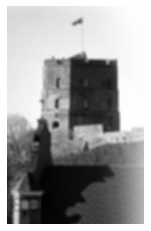

In [71]:
F = np.ones(shape=(5, 5)) / 25
plot(apply_filter(X, F))

### Line detection

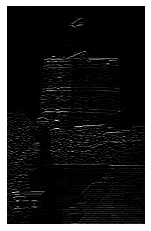

In [72]:
F = np.array([[-1, -1, -1],
              [ 2,  2,  2],
              [-1, -1, -1]])
plot(apply_filter(X, F))

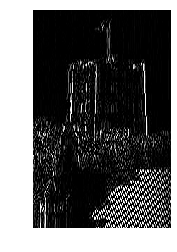

In [82]:
F = np.array([[-1, 2, -1],
              [-1, 2, -1],
              [-1, 2, -1]])
plot(apply_filter(X, F))

### Edge detection

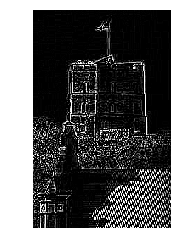

In [83]:
F = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]])
plot(apply_filter(X, F))

### The Sobel Edge Operator

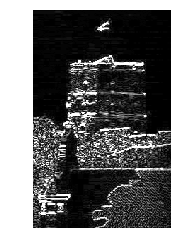

In [86]:
F_horizontal = np.array([[-1, -2, -1],
                         [ 0,  0,  0],
                         [ 1,  2,  1]])
F_vertical = np.array([[-1, -2, -1],
                       [ 0,  0,  0],
                       [ 1,  2,  1]])
plot(np.sqrt(apply_filter(X, F_horizontal)**2 + apply_filter(X, F_vertical)**2))

## Filters in Keras

CNN's in Keras do exactly the same thing as we did above, for example let's replicate line detection filter. First let's inititialize convolutional layer and pass input just to make sure that it works with random weights. Note that we need to add some axes to make it work.

In [73]:
conv = Conv2D(filters=1, kernel_size=(3, 3), padding='VALID')
conv(X[np.newaxis, :, :, np.newaxis].astype('float32')).shape

TensorShape([1, 310, 196, 1])

Now let's manually set weights.

In [74]:
F = np.array([[-1, -1, -1],
              [ 2,  2,  2],
              [-1, -1, -1]])

conv.set_weights([F[:, :, np.newaxis, np.newaxis], np.array([0.])])

Let's check if outputs looks as expected.

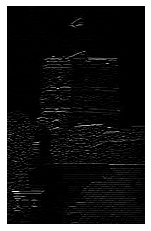

In [75]:
plot(conv(X[np.newaxis, :, :, np.newaxis].astype('float32'))[0, :, :, 0])

## CNN

### Super short history

In 1964 Hubel and Wiesel discovered some interesting facts about cats’ visual cortex (see [original video](https://www.youtube.com/watch?v=IOHayh06LJ4)). It turns out that there are specific neurons which react to different shapes, also it looks like there is hierarchical structures and basic forms are used as a basic building blocks for later neurons.

<img width=30% src="https://www.researchgate.net/profile/Anh_Nguyen44/publication/335707980/figure/fig1/AS:803803662127107@1568653135830/Fig-In-the-classic-neuroscience-experiment-Hubel-and-Wiesel-discovered-a-cats-visual.png"/>

In 1979 neocognitron was proposed by Kunihiko Fukushima and in 1980s CNN were finally developed. Le Couns group made them work on MNIST by intoducing LeNet-5 architecture.

<img width=70% src="https://miro.medium.com/max/4348/1*PXworfAP2IombUzBsDMg7Q.png"/>

Even though LeNet-5 was used for character recognition in some banks from 1980s, next real advancement came only in 2012 with AlexNet which won ImageNet competition at the time and was comprised of 60M parameters (compared to 60k used in LeNet-5). From that point CNN's only grew in size (see [top 10 architectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d)).

<img width=60% src="https://www.researchgate.net/profile/Sherif_Shehata2/publication/308880040/figure/fig3/AS:413548556636165@1475609067864/An-illustration-of-the-architecture-of-AlexNet-deep-convolutional-neural-network.png"/>

It turns out that CNN's do a similar thing as neurons in Hubel and Wiesels cortex model - lower levels detect simple shapes and in later layers they are combined.


### Implementation

Just as with simple fully connected networks you can try to write logic from scratch before jumping to using Keras or other ML library just to get deeper understanding of what is going on, for example see [this post](https://towardsdatascience.com/lets-code-convolutional-neural-network-in-plain-numpy-ce48e732f5d5).

Let's load MNIST dataset.

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
# Normalize (note that we add channel)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1) / 255

In [114]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[28, 28, 1]))
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
flatten_9 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1843300   
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 1,853,878
Trainable params: 1,853,878
Non-trainable params: 0
_________________________________________________________________


In [115]:
loss = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 68s 1ms/step - loss: 0.3984 - acc: 0.8854 - val_loss: 0.1903 - val_acc: 0.9450
Epoch 2/10
48000/48000 [==============================] - 67s 1ms/step - loss: 0.1673 - acc: 0.9500 - val_loss: 0.1482 - val_acc: 0.9563
Epoch 3/10
48000/48000 [==============================] - 78s 2ms/step - loss: 0.1228 - acc: 0.9630 - val_loss: 0.1101 - val_acc: 0.9674
Epoch 4/10
48000/48000 [==============================] - 84s 2ms/step - loss: 0.0989 - acc: 0.9700 - val_loss: 0.1002 - val_acc: 0.9710
Epoch 5/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.0818 - acc: 0.9752 - val_loss: 0.0952 - val_acc: 0.9728
Epoch 6/10
48000/48000 [==============================] - 66s 1ms/step - loss: 0.0702 - acc: 0.9781 - val_loss: 0.0929 - val_acc: 0.9714
Epoch 7/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.0607 - acc: 0.9814 - val_loss: 0.0833 - val_acc

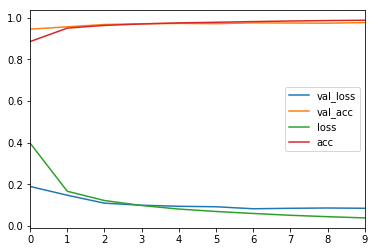

In [116]:
pd.DataFrame(loss.history).plot()

Using FCN we had 96.36% on test set.

In [117]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

Accuracy on test set - 97.72%


## What's next?

**NOTE:** LONG TRAINING TIME!

For faster training you can use [colab](https://colab.research.google.com/), just change it GPU mode by setting it at Edit -> Notebook settings -> Hardware accelerator.

There are multiple other tricks (Dropout, MaxPooling, ...) which can increse performance even more, but general CNN principle is still leading solution in image recognition.

We will look at these tricks later, but let's see what they can do.

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=[28, 28, 1]))
model.add(BatchNormalization(axis=-1))   # Axis -1 is always the features axis
model.add(Activation("relu"))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=-1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adadelta(),
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
__________

In [13]:
loss = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 138s 3ms/step - loss: 0.0053 - acc: 0.9982 - val_loss: 0.0586 - val_acc: 0.9885
Epoch 2/5
48000/48000 [==============================] - 134s 3ms/step - loss: 0.0039 - acc: 0.9988 - val_loss: 0.0469 - val_acc: 0.9890
Epoch 3/5
48000/48000 [==============================] - 145s 3ms/step - loss: 0.0042 - acc: 0.9985 - val_loss: 0.0487 - val_acc: 0.9906
Epoch 4/5
48000/48000 [==============================] - 112s 2ms/step - loss: 0.0033 - acc: 0.9988 - val_loss: 0.0574 - val_acc: 0.9902
Epoch 5/5
48000/48000 [==============================] - 102s 2ms/step - loss: 0.0031 - acc: 0.9991 - val_loss: 0.0677 - val_acc: 0.9889


In [15]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

Accuracy on test set - 98.98%


Usually in blogs and books you will find following implementation which uses dropout between CNN layers, but there is well known [critique](https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html) of this technique.

## Standard CNN implementation

In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=[28, 28, 1]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
__________

Let's add logger so that we can check outputs in tensorboard. To run tensorboard use: `tensorboard --logdir=./my_logs --port=6006`.

In [23]:
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
tensorboard_cb = TensorBoard(run_logdir)

In [24]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[tensorboard_cb])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 87s 2ms/step - loss: 0.2842 - acc: 0.9127 - val_loss: 0.0660 - val_acc: 0.9810
Epoch 2/10
48000/48000 [==============================] - 87s 2ms/step - loss: 0.0962 - acc: 0.9714 - val_loss: 0.0482 - val_acc: 0.9860
Epoch 3/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.0699 - acc: 0.9789 - val_loss: 0.0431 - val_acc: 0.9870
Epoch 4/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.0592 - acc: 0.9820 - val_loss: 0.0375 - val_acc: 0.9878
Epoch 5/10
48000/48000 [==============================] - 82s 2ms/step - loss: 0.0468 - acc: 0.9858 - val_loss: 0.0372 - val_acc: 0.9881
Epoch 6/10
48000/48000 [==============================] - 84s 2ms/step - loss: 0.0406 - acc: 0.9871 - val_loss: 0.0356 - val_acc: 0.9904
Epoch 7/10
48000/48000 [==============================] - 83s 2ms/step - loss: 0.0379 - acc: 0.9882 - val_loss: 0.0337 - val_acc

Go to [tensorboard](http://localhost:6006) and familarize with it while model is training.

In [25]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

Accuracy on test set - 99.25%


## So where are we on MNIST?

We tried RF, DNN and CNN for MNIST and managed to reproduced some of the key benchmarks out there

<img src="https://paper-attachments.dropbox.com/s_2E4854D97CFCA11CB3874DE15FA048AD21CE628C357A5C14D6A303FEC847FA36_1604825782553_image.png" style="width: 70%"/>

## Using CNN's for sequences

It turns out that same principle can applied for time series prediction. Here is a neat example based on Temporal Convolutional Nets (TCN).

In [2]:
%matplotlib inline

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 30 + 30))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 60 + 60)) # + wave 2
    series += 0.02 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 100
pred_steps = 20
series = generate_time_series(10000, n_steps + pred_steps)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -pred_steps:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -pred_steps:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -pred_steps:, 0]

Example of generated sequence

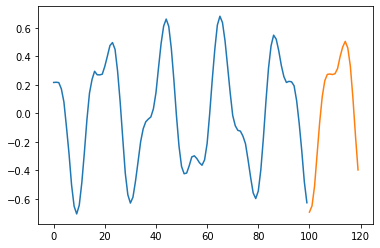

In [4]:
plt.plot(np.arange(n_steps), X_train[0])
plt.plot(np.arange(n_steps, n_steps + pred_steps), Y_train[0])

Great explanationa of simplified [TCN](https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb).

<img src="https://github.com/JEddy92/TimeSeries_Seq2Seq/raw/190fe87a9ea48bc5096b6417b7cb769aaa8887cf/notebooks/images/WaveNet_dilatedconv.png" style="width: 70%"/>

In [6]:
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(6)] 

history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last pred_steps time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':pred_steps})(x)

model = Model(history_seq, pred_seq_train)
model.summary()

model.compile(Adam(), loss='mean_absolute_error')

history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080  

Let's look at the predictions.

In [7]:
pred = model.predict(X_test)

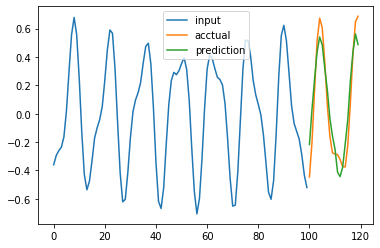

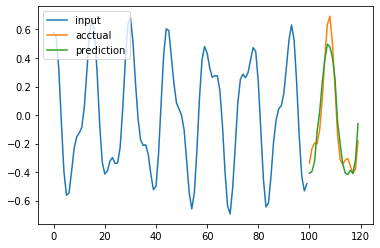

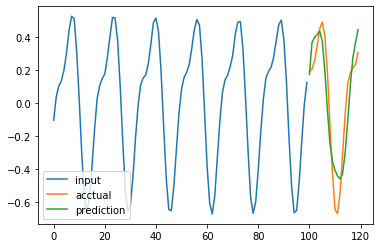

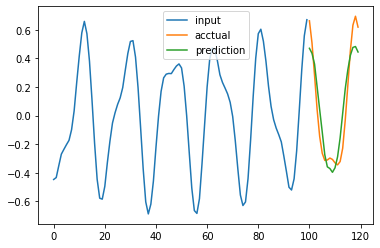

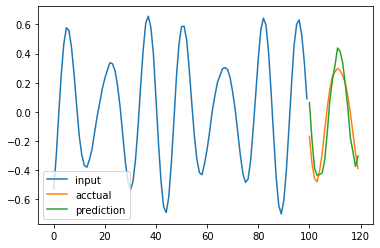

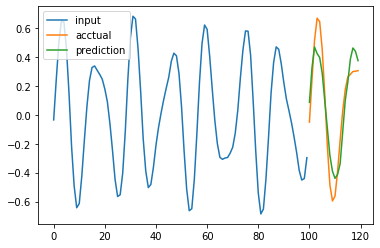

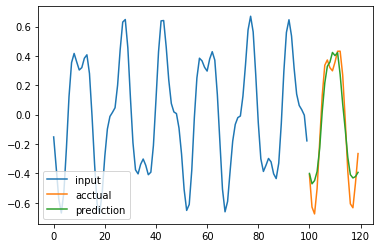

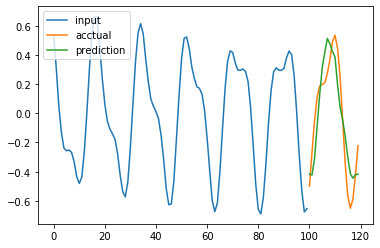

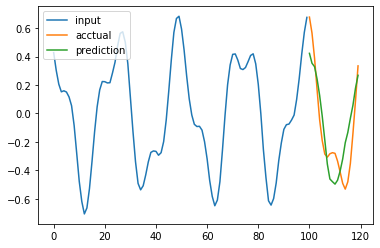

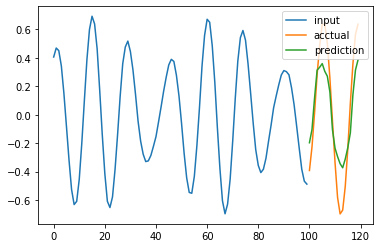

In [8]:
for i in range(10):
    plt.plot(np.arange(n_steps), X_test[i], label='input')
    plt.plot(np.arange(n_steps, n_steps + pred_steps), Y_test[i], label='acctual')
    plt.plot(np.arange(n_steps, n_steps + pred_steps), pred[i], label='prediction')
    plt.legend()
    plt.show()

I hope this example prooves universality and usefulness of Convolutional layers. For even crazier example of how filters (convolutionas) can be used look into [Neural Celural Automata](https://distill.pub/2020/growing-ca/).

## (re)Sources
- [Video explanation of CNN's](https://deeplizard.com/learn/video/YRhxdVk_sIs)
- [Top 10 architectures](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d)